<a href="https://colab.research.google.com/github/jatin-05/Potato-Disease-Classification/blob/main/training/TPU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [ ]:
ImageSize =256
BatchSize =32

In [ ]:
# !git clone https://github.com/jatin-05/Potato-Disease-Classification

Cloning into 'Potato-Disease-Classification'...
remote: Enumerating objects: 2174, done.
remote: Counting objects: 100% (2174/2174), done.
remote: Compressing objects: 100% (2169/2169), done.
remote: Total 2174 (delta 3), reused 2171 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (2174/2174), 38.64 MiB | 51.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
# %cd /content/Potato-Disease-Classification/training

/content/Potato-Disease-Classification/training


In [ ]:
dataset = tf.keras.preprocessing .image_dataset_from_directory(
    "PlantVillage" ,
    shuffle=True,
    image_size=(ImageSize,ImageSize) ,
    batch_size = BatchSize
)



Found 2152 files belonging to 3 classes.


In [ ]:

class_names =dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
68*32

2176

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:

for img_batch , label_batch in dataset.take(1):
    print (label_batch)
    print (label_batch.shape)
    print (img_batch[0])


tf.Tensor([1 2 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 2 0 0 0 0 1 1 1 0 0 1], shape=(32,), dtype=int32)
(32,)
tf.Tensor(
[[[150. 144. 154.]
  [154. 148. 158.]
  [161. 155. 165.]
  ...
  [123. 116. 123.]
  [122. 115. 122.]
  [125. 118. 125.]]

 [[155. 149. 159.]
  [156. 150. 160.]
  [158. 152. 162.]
  ...
  [121. 114. 121.]
  [118. 111. 118.]
  [119. 112. 119.]]

 [[161. 155. 165.]
  [157. 151. 161.]
  [155. 149. 159.]
  ...
  [120. 113. 120.]
  [117. 110. 117.]
  [116. 109. 116.]]

 ...

 [[147. 140. 147.]
  [145. 138. 145.]
  [144. 137. 144.]
  ...
  [ 94.  89.  96.]
  [ 95.  90.  97.]
  [ 97.  92.  99.]]

 [[140. 133. 140.]
  [144. 137. 144.]
  [148. 141. 148.]
  ...
  [ 96.  91.  98.]
  [ 97.  92.  99.]
  [ 99.  94. 101.]]

 [[137. 130. 137.]
  [146. 139. 146.]
  [155. 148. 155.]
  ...
  [ 95.  90.  97.]
  [ 96.  91.  98.]
  [ 97.  92.  99.]]], shape=(256, 256, 3), dtype=float32)


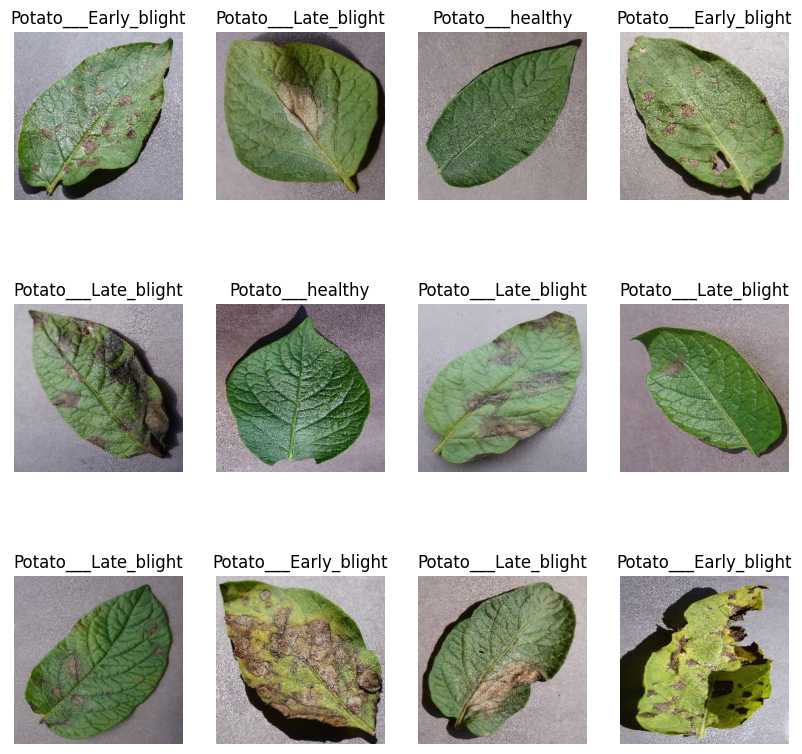

In [ ]:
plt.figure(figsize=(10,10))
for img_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.axis('off')
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])



### 80% ==> training
### 20% ==> 10% validation , 10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:


train_Ds = dataset.take(54)
len(train_Ds)

54

In [ ]:
test = dataset.skip(54)
len(test)

14

In [ ]:
val_Ds = test.take(7)
test_Ds = test.skip(7)

In [ ]:
def get_dataset_partitions_tf(ds , train_split= 0.8 , val_split = 0.1 , test_split= 0.1 , shuffle=True , shuffle_size = 1000 ):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size, seed =12)
        # what does seed do???????

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_Ds = ds.take(train_size)

    val_Ds = ds.skip(train_size).take(val_size)
    test_Ds = ds.skip(train_size).skip(val_size)

    return train_Ds , val_Ds , test_Ds



In [ ]:


train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(test_ds)

8

In [ ]:
len(val_ds)

6

In [ ]:
#cache stores the data in cache for the next epoch
# prefetch--> CPU fetches the next batch while GPU is trining the current batch (but you dont have a GPU :)  )
# buffer_size lets it decide how many batch to load while GPU is training

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# train_ds = train_ds.map(lambda x: x/255)
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical") ,
    layers.RandomRotation(0.2)
])

# model

In [ ]:
# input_shape = (  BatchSize , ImageSize , ImageSize , 3)  THIS MUS BE THE INPUT SHAPE BUT SINCE WE ARE USING MULTIPLE TPU, TPU STRATEGY ON ITS OWN DECITE WHAT SIZE MUST BE TO DIVE IT AMONG THEMSELVES
# we will not build here due to above reasons
# input_shape = ( BatchSize ,ImageSize , ImageSize , 3)
input_shape =(ImageSize , ImageSize , 3)
# manually applying data preprocessing but how would we generalize this to the new inut img given by user
def preprocess_image(image, label):
    image = resize_and_rescale(image)
    image = data_augmentation(image)
    return image, label

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

def get_model():
  model = models.Sequential([
      # resize_and_rescale ,
      # data_augmentation ,
      # Removed these layer due to tpu usage
      layers.Conv2D(32 , (3,3) ,activation='relu' , input_shape = input_shape),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu' ),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu' ),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu' ),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64 , (3,3) ,activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten() ,
      layers.Dense(64 , activation= 'relu'),
      layers.Dense(3 , activation= 'softmax'),


  ])
  # model.build(input_shape=input_shape)
  model.compile(
    optimizer = 'adam' ,
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics= ['accuracy']

 )
  return model

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'),
 PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'),
 PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]

In [ ]:
# only run this shitty code once otherwise it will crash
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
print("Tensorflow version " + tf.__version__)

Running on a TPU w/8 cores
Tensorflow version 2.18.0


In [ ]:



with tpu_strategy.scope():
  model=get_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
  history = model.fit(
    train_ds ,
    epochs=50 ,
    batch_size = BatchSize ,
    verbose =1 ,
    validation_data = val_ds ,


)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: nan - loss: nan - val_accuracy: 0.4392 - val_loss: 0.8213
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: nan - loss: nan - val_accuracy: 0.5239 - val_loss: 0.8301
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: nan - loss: nan - val_accuracy: 0.3830 - val_loss: 0.8191
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: nan - loss: nan - val_accuracy: 0.4309 - val_loss: 0.8934
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: nan - loss: nan - val_accuracy: 0.4972 - val_loss: 0.9351
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: nan - loss: nan - val_accuracy: 0.4996 - val_loss: 0.9357
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: nan - loss: nan - val_accuracy: 0.4102 - val_loss: 0.9326
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: nan - loss: nan - val_accuracy: 0.4192 - val_loss: 0.8474
Epoch 9/50
54/54

In [ ]:
score  = model.evaluate(test_ds )

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.8971 - loss: 0.3039


In [ ]:
score

[0.30923137068748474, 0.90625]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.4895833432674408,
 0.7106481194496155,
 0.8032407164573669,
 0.8466435074806213,
 0.8998842835426331,
 0.9178240895271301,
 0.9276620149612427,
 0.9403935074806213,
 0.9346064925193787,
 0.9461805820465088,
 0.9554398059844971,
 0.9560185074806213,
 0.953125,
 0.9398148059844971,
 0.9623842835426331,
 0.9618055820465088,
 0.96875,
 0.9571759104728699,
 0.9681712985038757,
 0.9809027910232544,
 0.9450231194496155,
 0.9675925970077515,
 0.9745370149612427,
 0.9722222089767456,
 0.9826388955116272,
 0.9728009104728699,
 0.9756944179534912,
 0.9722222089767456,
 0.9791666865348816,
 0.9780092835426331,
 0.9826388955116272,
 0.9924768805503845,
 0.9855324029922485,
 0.9733796119689941,
 0.9872685074806213,
 0.9866898059844971,
 0.9855324029922485,
 0.9733796119689941,
 0.9809027910232544,
 0.9913194179534912,
 0.9664351940155029,
 0.9832175970077515,
 0.9918981194496155,
 0.9826388955116272,
 0.9895833134651184,
 0.9953703880310059,
 0.9739583134651184,
 0.9751157164573669,
 0.9918981194

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



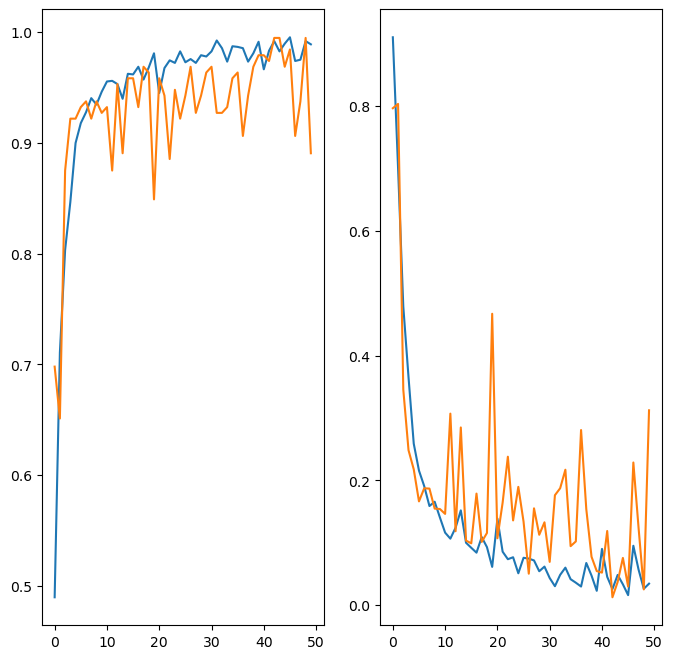

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50) , acc)

plt.plot(range(50) , val_acc)
plt.subplot(1,2,2)
plt.plot(range(50) , loss)
plt.plot(range(50) , val_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


NameError: name 'argmax' is not defined

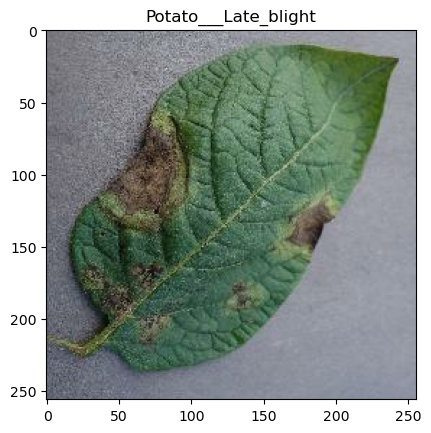

In [ ]:
for img , lab in test_ds.take(1):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(class_names[lab[0].numpy()])

    batch_pred = model.predict(img)
    print(argmax(batch_pred[0]))

In [ ]:
batch_pred[0]

array([2.9354844e-05, 9.9997067e-01, 3.2562875e-10], dtype=float32)